# DEPI Final Project -Predictive Maintenance-
## Students participat:
###  

1.  Yousef Khaled
2.  Mohamed Shady
3.  Mahmoud
4.  Ahmed Omar

# Introdction
Predictive maintenance’s main goal is to predict equipment failures based on certain parameters and factors. Once predicted, manufacturers take needed steps to prevent this failure with corrective or scheduled maintenance.

Predictive maintenance cannot exist without condition monitoring. Machines conduct continuous monitoring in real working conditions to ensure asset optimization. As with any maintenance strategy, predictive maintenance aims to:




*   Reduce breakdown occurrence and maximize asset uptime by improving asset reliability
*   Optimize operational costs by lowering maintenance work
*   Improve maintenance budgets by reducing maintenance costs and maximizing production time

## Predictive maintenance technologies
There is no singular technology that encompasses all of predictive maintenance. However, there are numerous condition-monitoring devices and techniques that manufacturers use to effectively predict failures and raise red flags when maintenance is needed.


1.   Infrared thermography
2.   Acoustic monitoring
3.   Vibration analysis
4.  Oil analysis

# Our Project
Our porject is generating a model predict failure accurate such as traditional tools used in preductive maintenance
according to some pramatars
such as:

*   Temprature
*   pressure
*   Speed
*   Torque
*   operatrion



#  Import Necessary Libraries

In [1]:
import mlflow
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# filter Warnings
import warnings
warnings.filterwarnings('ignore')

# Read the dataset

In [3]:

df = pd.read_csv('predictive_maintenance.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


# Data Analysis

## Data Shape

In [4]:
df.shape

(10000, 10)

## Data Information

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


## Data Description

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
UDI,10000.0,5000.50000,2886.895680,1.0,2500.75,5000.5,7500.25,10000.0
Air temperature [K],10000.0,300.00493,2.000259,295.3,298.30,300.1,301.50,304.5
Process temperature [K],10000.0,310.00556,1.483734,305.7,308.80,310.1,311.10,313.8
Rotational speed [rpm],10000.0,1538.77610,179.284096,1168.0,1423.00,1503.0,1612.00,2886.0
Torque [Nm],10000.0,39.98691,9.968934,3.8,33.20,40.1,46.80,76.6
Tool wear [min],10000.0,107.95100,63.654147,0.0,53.00,108.0,162.00,253.0
Target,10000.0,0.03390,0.180981,0.0,0.00,0.0,0.00,1.0


## Data Description of Objective Data Types

In [7]:
df.describe(include= 'object')

,Product ID,Type,Failure Type
count,10000,10000,10000
unique,10000,3,6
top,M14860,L,No Failure
freq,1,6000,9652


## Check Null vales in Data set

In [8]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

## Check Duplicate values In the Dataset

In [9]:
df.duplicated().sum()

0

## Droping unnecessary columns 

In [10]:
df.drop(df.columns[:2], axis=1, inplace= True)

## Check Dataset Shape Again

In [11]:
df.shape

(10000, 8)

## Filtering Categorical Calumns

In [12]:
cat_cols= df.select_dtypes(include= 'O').columns.tolist()

## Print Categorical Columns

In [13]:
cat_cols

['Type', 'Failure Type']

## value counts for categorical columns

In [14]:
for col in cat_cols:
    print(df[col].value_counts())

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64
Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64


## Identify faulty machines with 'Taregt' value 1

In [15]:
df_f = df[df.Target==1]
df_f['Failure Type'].value_counts()

Failure Type
Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
No Failure                    9
Name: count, dtype: int64

## Drop No failure Rows that shows the Failure But Actually they are not

In [16]:
idx= df_f[df_f['Failure Type']== 'No Failure'].index
df.drop(idx, axis=0, inplace= True)


## Identify faulty machines with 'Taregt' value 0

In [17]:
df_f = df[df.Target==0]
df_f['Failure Type'].value_counts()

Failure Type
No Failure         9643
Random Failures      18
Name: count, dtype: int64

## Drop Not random Failure Which are not actually Failure 

In [18]:
idx= df_f[df_f['Failure Type']== 'Random Failures'].index
df.drop(idx, axis=0, inplace= True)

## Shape Check

In [19]:
df.shape

(9973, 8)

## Identify numerical Columns

In [20]:
num_cols= df.select_dtypes(exclude='O').columns.tolist()
num_cols

['Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]',
 'Target']

## Handling the Outliers in data

In [21]:
df.replace([np.inf, -np.inf], np.nan, inplace= True)

# Data Visualization

## Boxplot for all variables

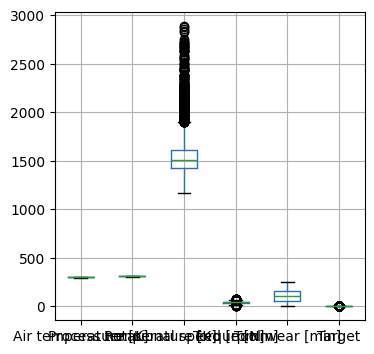

In [22]:
plt.figure(figsize=(4,4))
df.boxplot(figsize= (15,10))
plt.show()

<Axes: ylabel='Rotational speed [rpm]'>

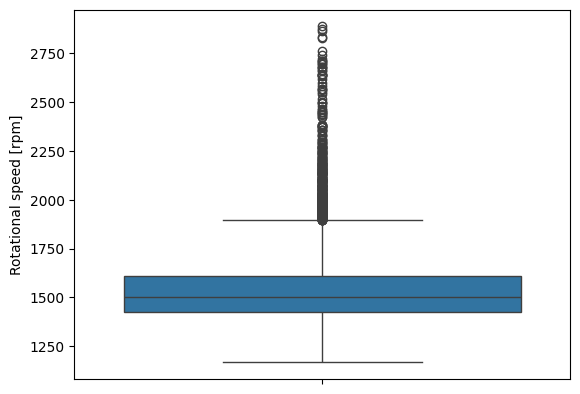

In [23]:
sns.boxplot(df['Rotational speed [rpm]'])

## Skewness of Rotational Speed

<Axes: xlabel='Rotational speed [rpm]', ylabel='Density'>

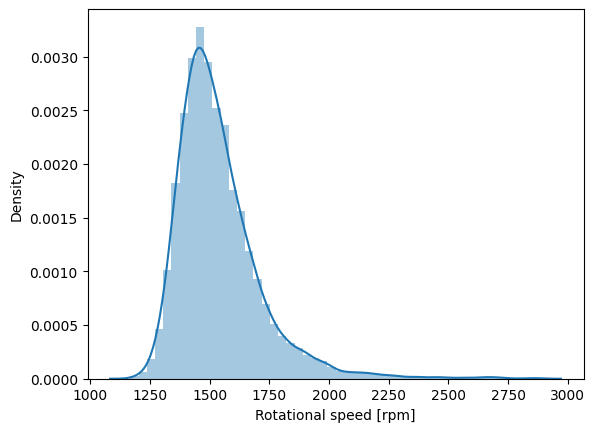

In [24]:
sns.distplot(df['Rotational speed [rpm]'])

## Skewness value
This Distribution plot looks like Right Skewed

In [25]:
from scipy.stats import skew

skewness = skew(df['Rotational speed [rpm]'])
print('Skewness: ', skewness)

Skewness:  1.9925593351071693


# Data Preprocessing
## Removing Outliers Using IQR Method

In [26]:
q1 = df['Rotational speed [rpm]'].quantile(0.25)
q3 = df['Rotational speed [rpm]'].quantile(0.75)

iqr = q3- q1

lower_limit = q1- 1.5 * iqr
upper_limit = q3 +1.5 * iqr

df = df[(df['Rotational speed [rpm]'] >= lower_limit) & 
        (df['Rotational speed [rpm]'] <= upper_limit)]

df.shape

(9555, 8)

## Pair Plot

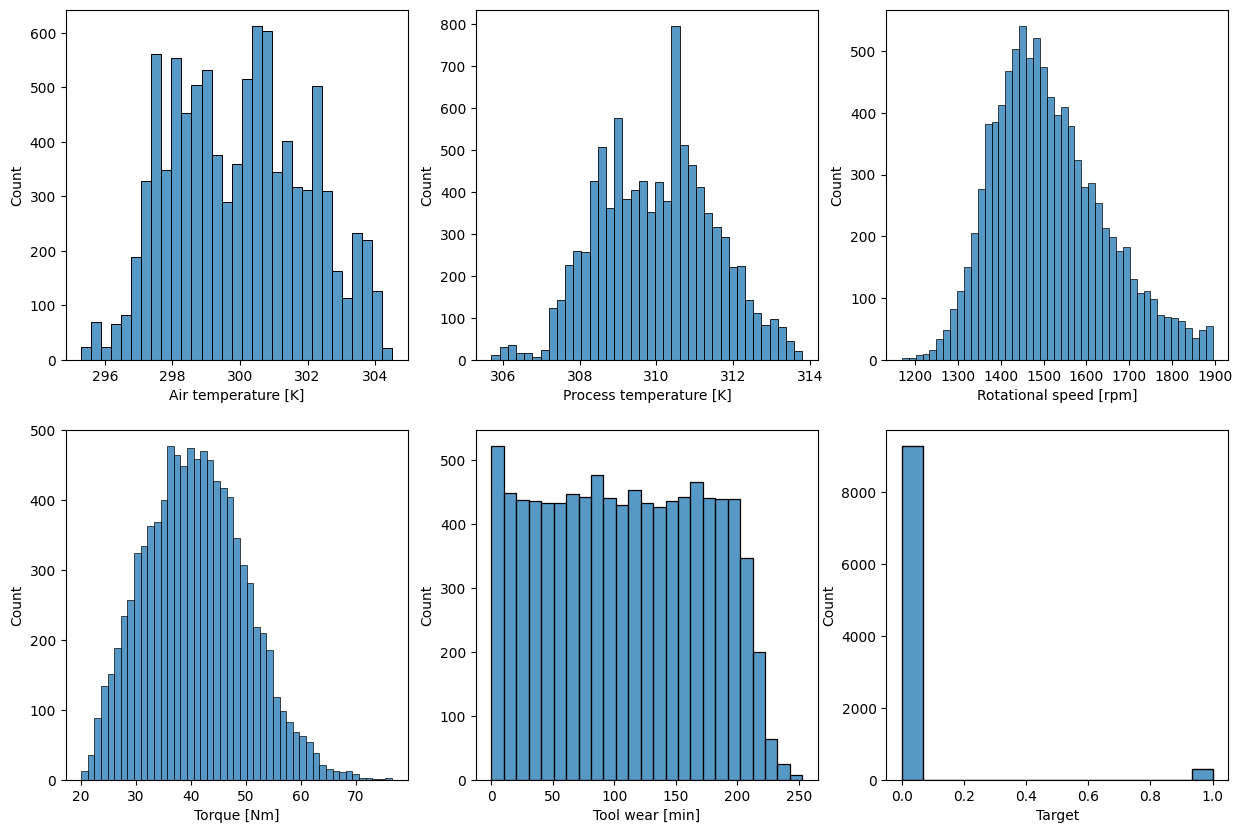

In [27]:
plt.figure(figsize= (15,10))

for i, col in  enumerate(num_cols, 1):
    plt.subplot(2,3,i)
    sns.histplot(data= df, x= col)
plt.show()

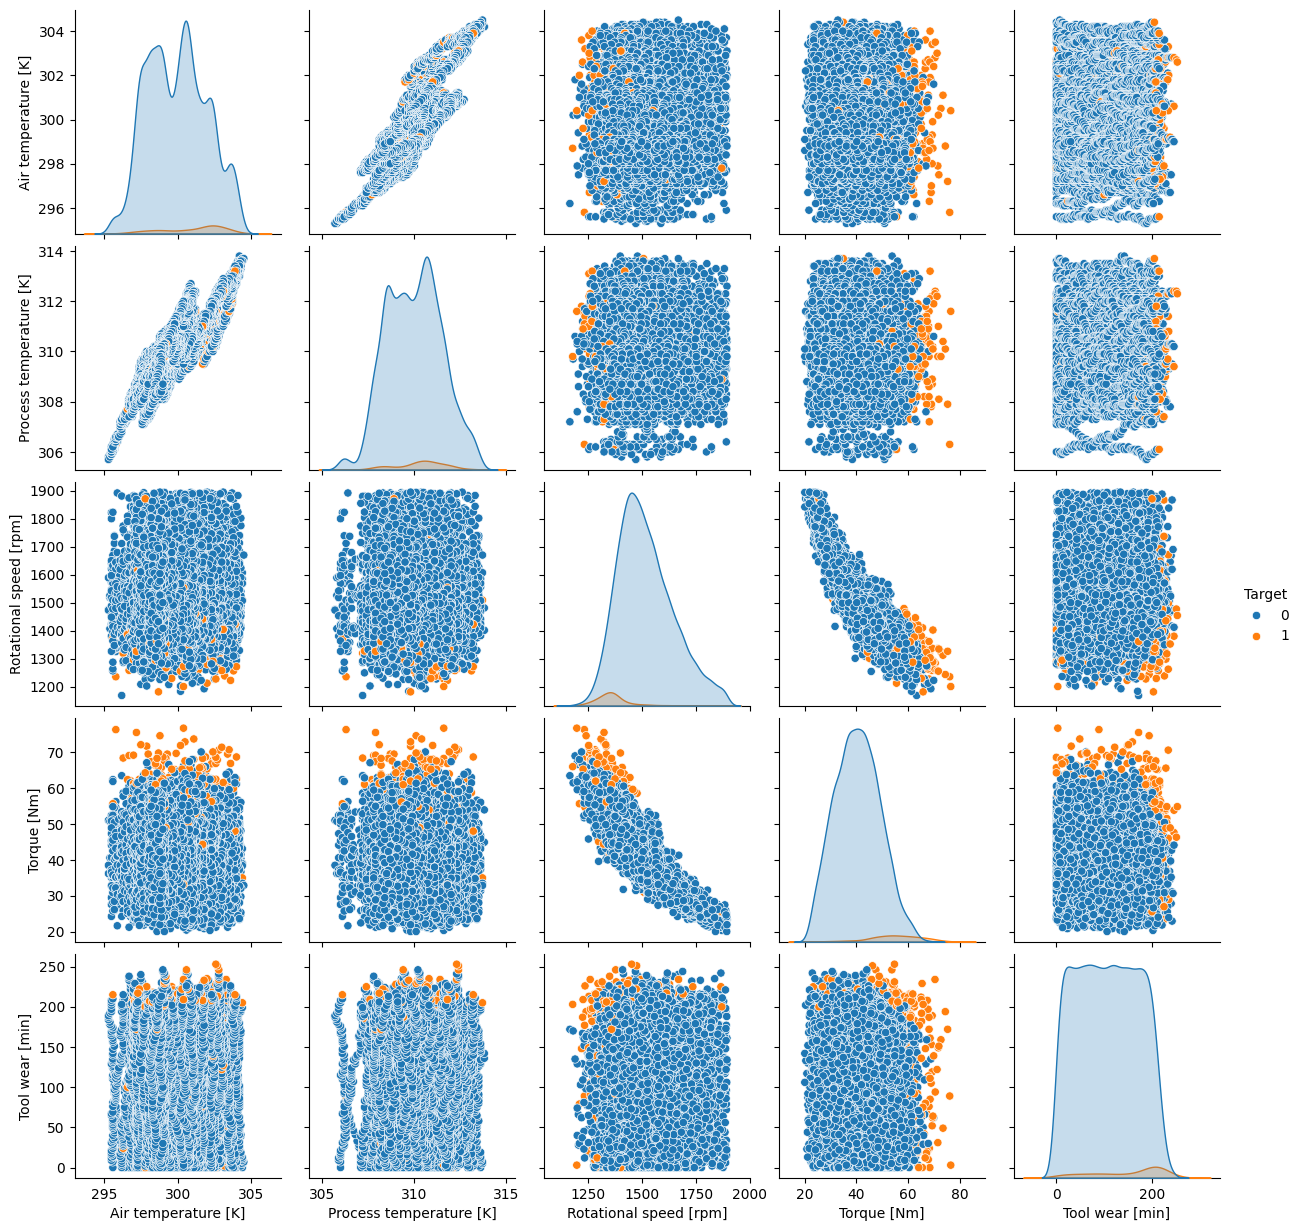

In [28]:
sns.pairplot(df, hue= 'Target')
plt.show()

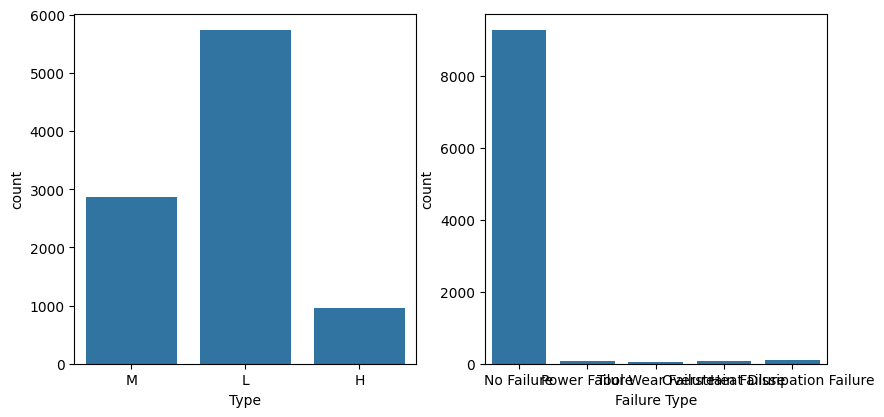

In [29]:
plt.figure(figsize= (15,10))

for i, col in  enumerate(cat_cols, 1):
    plt.subplot(2,3,i)
    sns.countplot(data= df, x= col)
plt.show()

<Axes: >

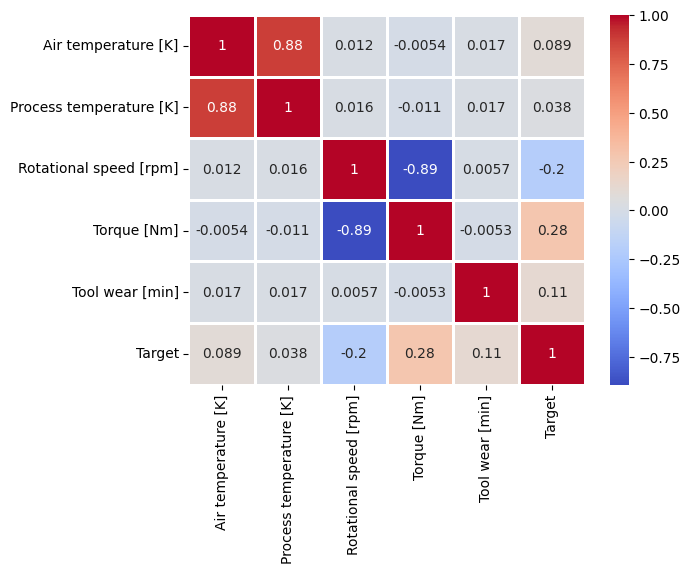

In [30]:
sns.heatmap(df.corr(numeric_only= True), annot= True, cmap= 'coolwarm', linewidths=2)

## Separate data to x & y

In [31]:
x= df.drop(['Target', 'Failure Type'], axis= 1)
y= df['Target']

x.shape, y.shape

((9555, 6), (9555,))

## Splitting Data Into Train and test

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(x,y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7644, 6), (1911, 6), (7644,), (1911,))

## Filtering the Categorical and Numerical Features for the Further Analysis and Operations

In [33]:
cat_cols= X_train.select_dtypes(include= "O").columns.tolist()
num_cols= X_train.select_dtypes(exclude= "O").columns.tolist()
cat_cols, num_cols

(['Type'],
 ['Air temperature [K]',
  'Process temperature [K]',
  'Rotational speed [rpm]',
  'Torque [Nm]',
  'Tool wear [min]'])

## Column Transformation For the Numerical and categorical features

In [34]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

enc= OneHotEncoder(handle_unknown= 'ignore')
sc= StandardScaler()

ct= ColumnTransformer(
        [
            ('encoding', enc, cat_cols),
            ('scaling', sc, num_cols)
        ]
)

X_train= ct.fit_transform(X_train)
X_test = ct.transform(X_test)

X_train_columns=ct.get_feature_names_out()


# Modeling
## MLflow Logging

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, recall_score, precision_score, f1_score

def log_mlflow_metrics(model_name, clf, X_train, y_train, X_test, y_test):
    # Make predictions for both train and test data
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    print(f"Classification Report for {model_name}:\n")
    print("Train Data:\n", classification_report(y_train, y_pred_train))
    print("Test Data:\n", classification_report(y_test, y_pred_test))
    
    # Calculate metrics for test data
    accuracy_test = accuracy_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    roc_auc_test = roc_auc_score(y_test, y_pred_test)
    
    # Calculate metrics for train data
    accuracy_train = accuracy_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train)
    roc_auc_train = roc_auc_score(y_train, y_pred_train)
    
    # Confusion Matrix for test data
    conf_matrix_test = confusion_matrix(y_test, y_pred_test)
    
    # Start MLflow experiment
    experiment = mlflow.get_experiment_by_name("Predictive Maintenance ML model")
    if experiment is None:
        id = mlflow.create_experiment("Predictive Maintenance ML model")
    else:
        id = experiment.experiment_id
    
    with mlflow.start_run(experiment_id=id, run_name=model_name):
        # Log the preprocessed dataset
        dataset = pd.concat([pd.DataFrame(X_train, columns=X_train_columns), pd.DataFrame(y_train, columns=["Target"])], axis=1)
        dataset = mlflow.data.pandas_dataset.from_pandas(dataset, name="predictive_maintenance_dataset", targets="Target")
        mlflow.log_input(dataset, context="training_data")

        # Log model parameters
        mlflow.log_params(clf.get_params())
        
        # Log train & test metrics
        mlflow.log_metric("test_accuracy", accuracy_test)
        mlflow.log_metric("train_accuracy", accuracy_train)
        mlflow.log_metric("test_recall", recall_test)
        mlflow.log_metric("train_recall", recall_train)
        mlflow.log_metric("test_precision", precision_test)
        mlflow.log_metric("train_precision", precision_train)
        mlflow.log_metric("test_f1", f1_test)
        mlflow.log_metric("train_f1", f1_train)
        mlflow.log_metric("test_roc_auc", roc_auc_test)
        mlflow.log_metric("train_roc_auc", roc_auc_train)
        
        # Plot and log confusion matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
        plt.title(f'Confusion Matrix - {model_name}')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.savefig(f"{model_name}_confusion_matrix.png")
        mlflow.log_artifact(f"{model_name}_confusion_matrix.png")
        
        # Plot and log ROC curve
        fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
        plt.figure()
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.savefig(f"{model_name}_roc_curve.png")
        mlflow.log_artifact(f"{model_name}_roc_curve.png")
        
        # Log the model
        mlflow.sklearn.log_model(clf, "model")

        mlflow.end_run()

## Logistic Regression Model

Classification Report for Logistic Regression:

Train Data:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      7399
           1       0.72      0.24      0.36       245

    accuracy                           0.97      7644
   macro avg       0.85      0.62      0.67      7644
weighted avg       0.97      0.97      0.97      7644

Test Data:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1861
           1       0.77      0.20      0.32        50

    accuracy                           0.98      1911
   macro avg       0.87      0.60      0.65      1911
weighted avg       0.97      0.98      0.97      1911



2024/10/13 17:37:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


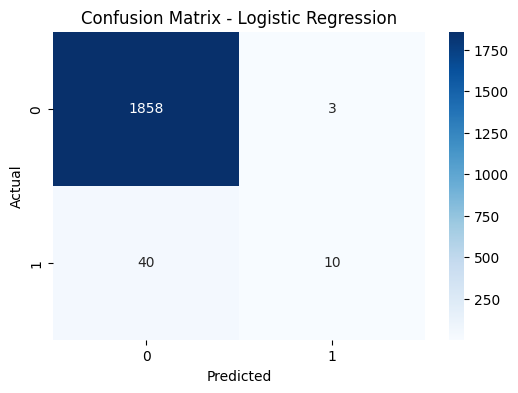

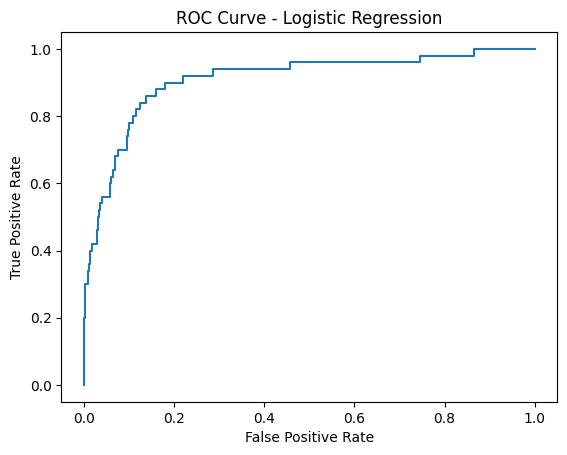

In [36]:
from sklearn.linear_model import LogisticRegression

# Train model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Log metrics and model with MLflow
log_mlflow_metrics("Logistic Regression", clf, X_train, y_train, X_test, y_test)

## Support Vector Machines

Classification Report for SVM:

Train Data:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      7399
           1       0.91      0.36      0.52       245

    accuracy                           0.98      7644
   macro avg       0.94      0.68      0.75      7644
weighted avg       0.98      0.98      0.97      7644

Test Data:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1861
           1       0.92      0.24      0.38        50

    accuracy                           0.98      1911
   macro avg       0.95      0.62      0.69      1911
weighted avg       0.98      0.98      0.97      1911



2024/10/13 17:37:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


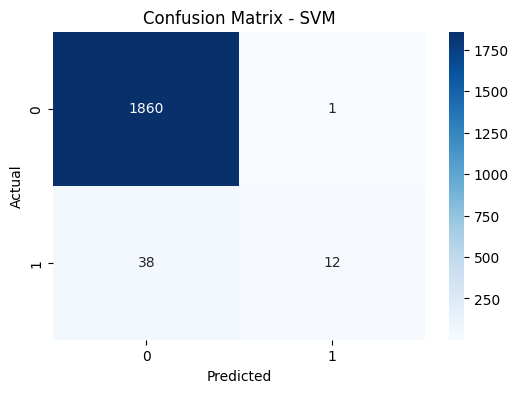

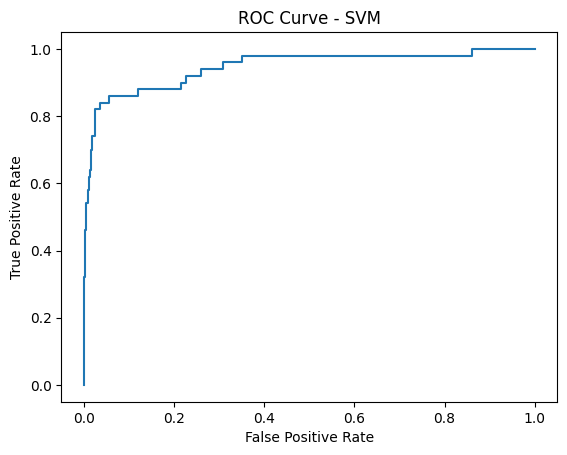

In [37]:
from sklearn.svm import SVC

# Train model
svm = SVC(probability=True)
svm.fit(X_train, y_train)

# Log metrics and model with MLflow
log_mlflow_metrics("SVM", svm, X_train, y_train, X_test, y_test)


## SVM Model with RBF Kernel

Classification Report for SVM RBF:

Train Data:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      7399
           1       0.91      0.36      0.52       245

    accuracy                           0.98      7644
   macro avg       0.94      0.68      0.75      7644
weighted avg       0.98      0.98      0.97      7644

Test Data:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1861
           1       0.92      0.24      0.38        50

    accuracy                           0.98      1911
   macro avg       0.95      0.62      0.69      1911
weighted avg       0.98      0.98      0.97      1911



2024/10/13 17:37:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


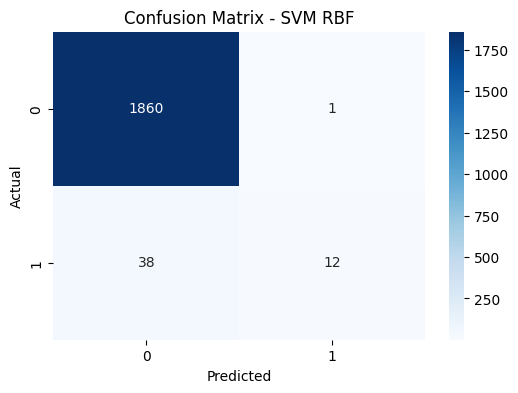

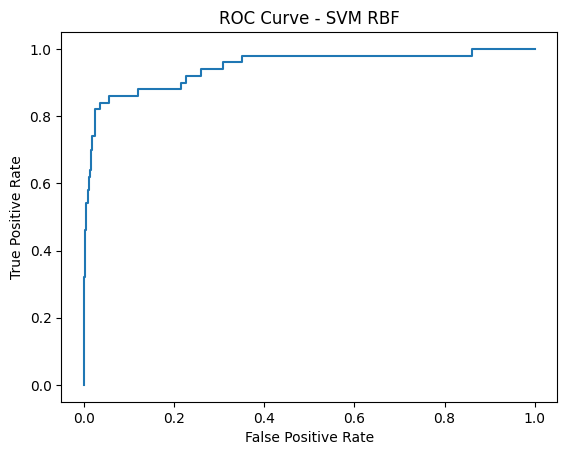

In [38]:
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score

# SVM with RBF Kernel and Metrics Calculation
rbf = SVC(kernel='rbf', probability=True)  # Enable probability for ROC curve
rbf.fit(X_train, y_train)

# Log metrics and model with MLflow
log_mlflow_metrics("SVM RBF", rbf, X_train, y_train, X_test, y_test)

## Decision Tree

Classification Report for Decision Tree:

Train Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7399
           1       1.00      1.00      1.00       245

    accuracy                           1.00      7644
   macro avg       1.00      1.00      1.00      7644
weighted avg       1.00      1.00      1.00      7644

Test Data:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1861
           1       0.58      0.64      0.61        50

    accuracy                           0.98      1911
   macro avg       0.79      0.81      0.80      1911
weighted avg       0.98      0.98      0.98      1911



2024/10/13 17:37:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


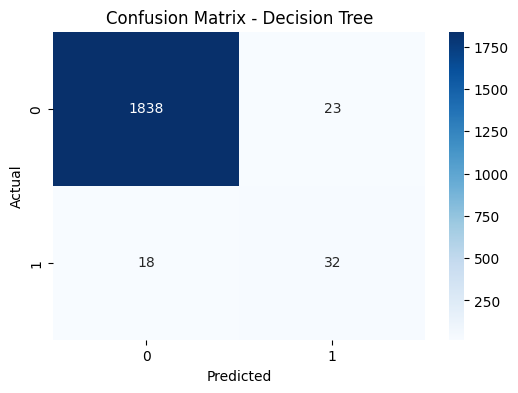

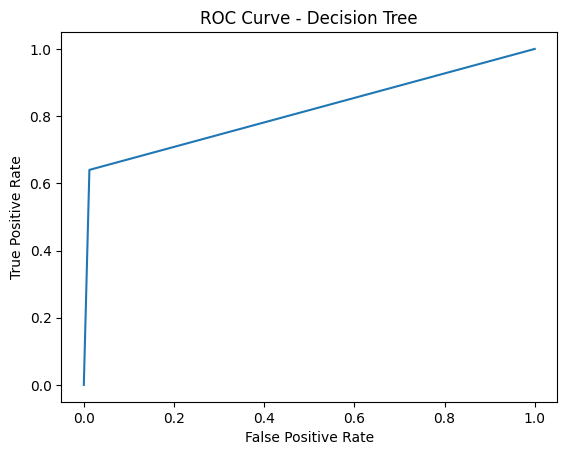

In [39]:
from sklearn.tree import DecisionTreeClassifier

# Train model
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

# Log metrics and model with MLflow
log_mlflow_metrics("Decision Tree", tree, X_train, y_train, X_test, y_test)

## Random Forest

Classification Report for Random Forest:

Train Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7399
           1       1.00      1.00      1.00       245

    accuracy                           1.00      7644
   macro avg       1.00      1.00      1.00      7644
weighted avg       1.00      1.00      1.00      7644

Test Data:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1861
           1       0.88      0.46      0.61        50

    accuracy                           0.98      1911
   macro avg       0.94      0.73      0.80      1911
weighted avg       0.98      0.98      0.98      1911



2024/10/13 17:37:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


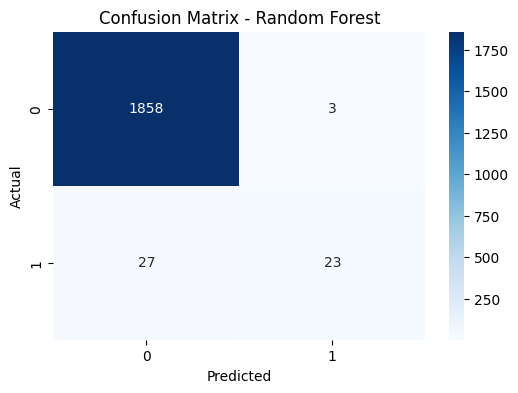

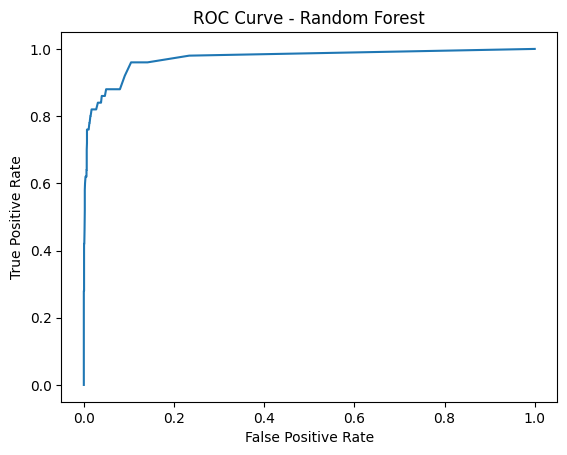

In [40]:
import mlflow
import mlflow.sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score

# Random Forest Model
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

# Log metrics and model with MLflow
log_mlflow_metrics("Random Forest", forest, X_train, y_train, X_test, y_test)

## SMOTE (Synthetic Minority OverSampling Technique)

In [41]:
# Apply Smote for the data balance
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
X_resampled.shape, X_train.shape

((14798, 8), (7644, 8))

## Logistic Regression Model After SMOTE

Classification Report for Logistic Regression SMOTE:

Train Data:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      7399
           1       0.86      0.88      0.87      7399

    accuracy                           0.87     14798
   macro avg       0.87      0.87      0.87     14798
weighted avg       0.87      0.87      0.87     14798

Test Data:
               precision    recall  f1-score   support

           0       1.00      0.85      0.92      1861
           1       0.13      0.86      0.23        50

    accuracy                           0.85      1911
   macro avg       0.56      0.86      0.57      1911
weighted avg       0.97      0.85      0.90      1911



2024/10/13 17:37:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


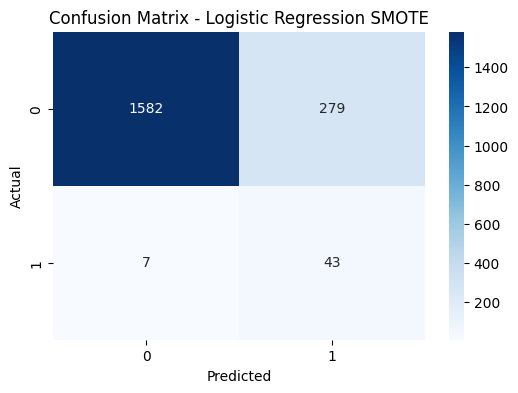

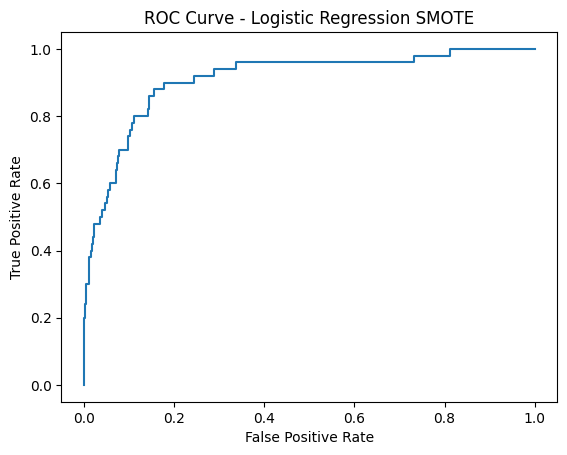

In [42]:
# Fit the logistic regression model on the resampled dataset
clf.fit(X_resampled, y_resampled)

# Log metrics and model with MLflow
log_mlflow_metrics("Logistic Regression SMOTE", clf, X_resampled, y_resampled, X_test, y_test)

## SVM After SMOTE

Classification Report for SVM SMOTE:

Train Data:
               precision    recall  f1-score   support

           0       0.99      0.94      0.97      7399
           1       0.94      0.99      0.97      7399

    accuracy                           0.97     14798
   macro avg       0.97      0.97      0.97     14798
weighted avg       0.97      0.97      0.97     14798

Test Data:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97      1861
           1       0.28      0.90      0.43        50

    accuracy                           0.94      1911
   macro avg       0.64      0.92      0.70      1911
weighted avg       0.98      0.94      0.95      1911



2024/10/13 17:37:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


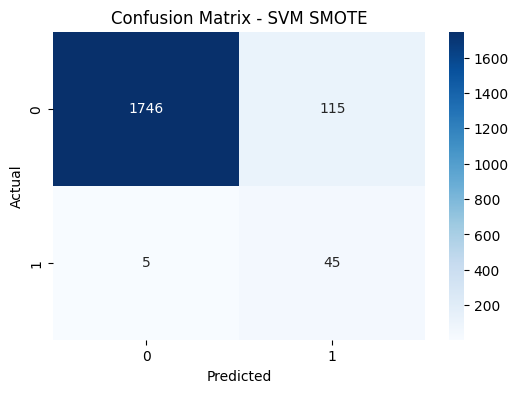

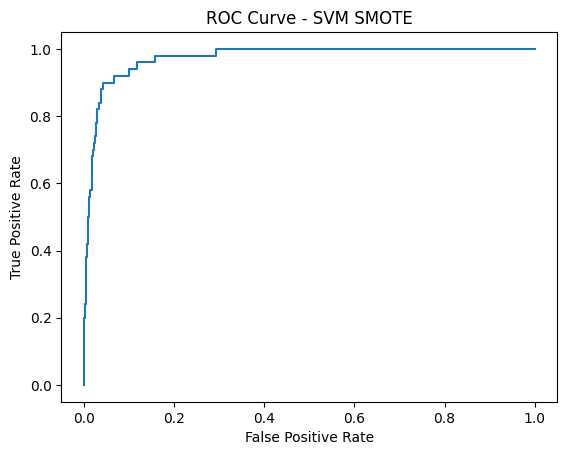

In [43]:
# Train the SVM model on the resampled dataset
svm.fit(X_resampled, y_resampled)

# Log metrics and model with MLflow
log_mlflow_metrics("SVM SMOTE", svm, X_resampled, y_resampled, X_test, y_test)

## Decision Tree After SMOTE

Classification Report for Decision Tree SMOTE:

Train Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7399
           1       1.00      1.00      1.00      7399

    accuracy                           1.00     14798
   macro avg       1.00      1.00      1.00     14798
weighted avg       1.00      1.00      1.00     14798

Test Data:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1861
           1       0.53      0.80      0.63        50

    accuracy                           0.98      1911
   macro avg       0.76      0.89      0.81      1911
weighted avg       0.98      0.98      0.98      1911



2024/10/13 17:37:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


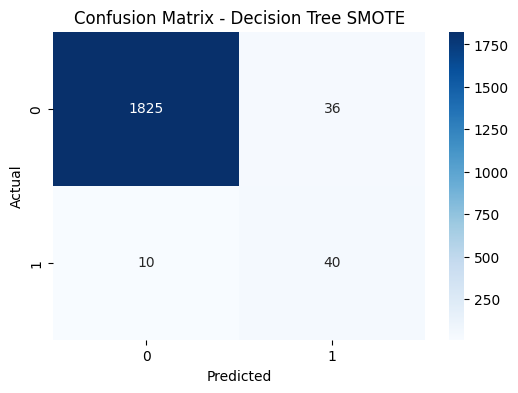

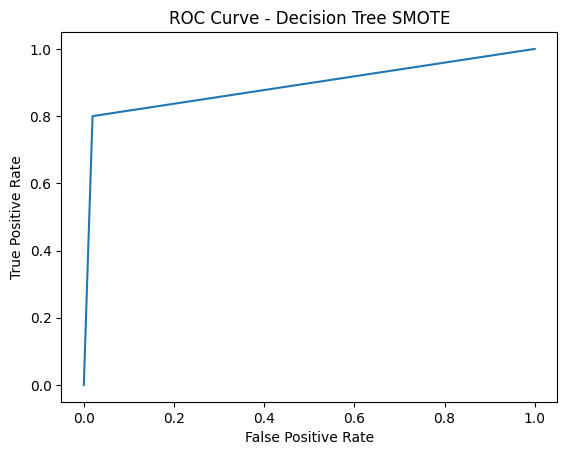

In [44]:
# Train the Decision Tree model on the resampled dataset
tree.fit(X_resampled, y_resampled)

# Log metrics and model with MLflow
log_mlflow_metrics("Decision Tree SMOTE", tree, X_resampled, y_resampled, X_test, y_test)

## Random Forest after SMOTE

Classification Report for Random Forest SMOTE:

Train Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7399
           1       1.00      1.00      1.00      7399

    accuracy                           1.00     14798
   macro avg       1.00      1.00      1.00     14798
weighted avg       1.00      1.00      1.00     14798

Test Data:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      1861
           1       0.44      0.74      0.55        50

    accuracy                           0.97      1911
   macro avg       0.72      0.86      0.77      1911
weighted avg       0.98      0.97      0.97      1911



2024/10/13 17:37:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


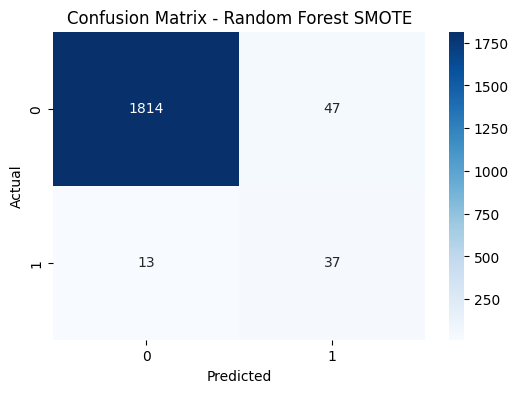

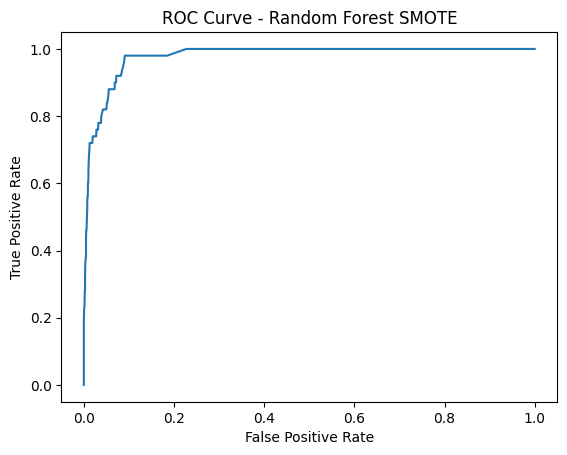

In [45]:
# Train the Random Forest model on the resampled dataset
forest.fit(X_resampled, y_resampled)

# Log metrics and model with MLflow
log_mlflow_metrics("Random Forest SMOTE", forest, X_resampled, y_resampled, X_test, y_test)